In [14]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
df = pd.read_csv('multivariate_eng_df.csv', parse_dates=['Date']).drop(columns=['Unnamed: 0'])

In [15]:
#separate df for california -- multivariate still
ca_df = df.loc[df['PROVINCE_STATE_NAME'] == 'California']
ca_df.drop(columns = ['STATE', 'PROVINCE_STATE_NAME'], inplace = True)
ca_df.head(3)

,Date,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_65Plus,Series_Complete_Yes,Series_Complete_5Plus,Series_Complete_5to17,...,vaccination_rate_complete,booster_rate,prop_age04,prop_age59,prop_age6064,prop_age8084,prop_age85plus,AGE04_29_TOT,AGE30_59_TOT,AGE60PLUS_TOT
0,2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
1,2020-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2,2020-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914


In [16]:
#separate train & test sets
train_size = int(len(ca_df)* 0.85)
ca_train, ca_test = ca_df[0:train_size], ca_df[train_size:]

In [18]:
#identify best features among 179 using PCA -- to help speed up 
X_ca_train = ca_train.drop(columns=['PEOPLE_POSITIVE_NEW_CASES_COUNT']) 
X_ca_test = ca_test.drop(columns=['PEOPLE_POSITIVE_NEW_CASES_COUNT']) 
y_ca_train = ca_train['PEOPLE_POSITIVE_NEW_CASES_COUNT']
y_ca_test = ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT']

# Keep the 'Date' column separate and not to be scaled or PCA-transformed
Date_train = X_ca_train[['Date']].reset_index(drop=True)
Date_test = X_ca_test[['Date']].reset_index(drop=True)

# Exclude the 'Date' column from scaling and PCA
X_train_ca_numerical = X_ca_train.drop(columns=['Date'])
X_test_ca_numerical = X_ca_test.drop(columns=['Date'])


#standardize the features (mean=0 and variance=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ca_numerical)
X_test_scaled = scaler.fit_transform(X_test_ca_numerical)

#PCA to reduce the features to the top 40 principal components
pca = PCA(n_components=40)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

#transformed data `X_pca` has only the top 40 principal components now
X_train_pca_df = pd.DataFrame(data = X_train_pca)
X_test_pca_df = pd.DataFrame(data = X_test_pca)

# Concatenate the PCA components with the 'Date' column
X_train_final = pd.concat([Date_train, X_train_pca_df], axis=1)
X_test_final = pd.concat([Date_test, X_test_pca_df], axis=1)

In [24]:
#forward selection algorithm to determine optimal feature combination for multivariate prophet model
target_column = 'PEOPLE_POSITIVE_NEW_CASES_COUNT'

# Updated forward selection function to include target data as separate arguments
def forward_selection(train_df, test_df, y_train, y_test, target_column):
    train_df.columns = train_df.columns.astype(str)
    test_df.columns = test_df.columns.astype(str)

    features = [col for col in train_df.columns if col != 'Date']
    included_features = []
    best_mae = np.inf
    improvement = True
    
    while improvement and features:
        improvement = False
        for feature in features:
            test_features = included_features + [feature]
            
            # Initialize and setup Prophet model
            model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
            for f in test_features:
                model.add_regressor(f, standardize=False)
                
            # Prepare training data
            train_data = train_df[['Date'] + test_features]
            train_data['y'] = y_train
            train_data = train_data.rename(columns={'Date': 'ds'})
            
            model.fit(train_data)
            
            # Prepare testing data
            test_data = test_df[['Date'] + test_features]
            test_data['y'] = y_test  # This line is not used for prediction but kept for consistency
            test_data = test_data.rename(columns={'Date': 'ds'})
            
            forecast = model.predict(test_data.drop(columns=['y']))
            
            # Evaluate the model
            mae = mean_absolute_error(y_test, forecast['yhat'])
            
            if mae < best_mae:
                best_feature = feature
                best_mae = mae
                improvement = True
                
        if improvement:
            included_features.append(best_feature)
            features.remove(best_feature)
            print(f"Added {best_feature} to the model, new best MAE: {best_mae}")
    
    print(f"Final features selected: {included_features}")
    return included_features


In [25]:
# Run the updated forward selection
selected_features = forward_selection(X_train_final, X_test_final, y_ca_train, y_ca_test, target_column)

14:57:45 - cmdstanpy - INFO - Chain [1] start processing
14:57:46 - cmdstanpy - INFO - Chain [1] done processing
14:57:46 - cmdstanpy - INFO - Chain [1] start processing
14:57:46 - cmdstanpy - INFO - Chain [1] done processing
14:57:46 - cmdstanpy - INFO - Chain [1] start processing
14:57:46 - cmdstanpy - INFO - Chain [1] done processing
14:57:46 - cmdstanpy - INFO - Chain [1] start processing
14:57:47 - cmdstanpy - INFO - Chain [1] done processing
14:57:47 - cmdstanpy - INFO - Chain [1] start processing
14:57:47 - cmdstanpy - INFO - Chain [1] done processing
14:57:47 - cmdstanpy - INFO - Chain [1] start processing
14:57:47 - cmdstanpy - INFO - Chain [1] done processing
14:57:47 - cmdstanpy - INFO - Chain [1] start processing
14:57:47 - cmdstanpy - INFO - Chain [1] done processing
14:57:47 - cmdstanpy - INFO - Chain [1] start processing
14:57:47 - cmdstanpy - INFO - Chain [1] done processing
14:57:48 - cmdstanpy - INFO - Chain [1] start processing
14:57:48 - cmdstanpy - INFO - Chain [1]

Added 2 to the model, new best MAE: 28841.87213871731


14:57:55 - cmdstanpy - INFO - Chain [1] done processing
14:57:56 - cmdstanpy - INFO - Chain [1] start processing
14:57:56 - cmdstanpy - INFO - Chain [1] done processing
14:57:56 - cmdstanpy - INFO - Chain [1] start processing
14:57:56 - cmdstanpy - INFO - Chain [1] done processing
14:57:56 - cmdstanpy - INFO - Chain [1] start processing
14:57:56 - cmdstanpy - INFO - Chain [1] done processing
14:57:56 - cmdstanpy - INFO - Chain [1] start processing
14:57:56 - cmdstanpy - INFO - Chain [1] done processing
14:57:57 - cmdstanpy - INFO - Chain [1] start processing
14:57:57 - cmdstanpy - INFO - Chain [1] done processing
14:57:57 - cmdstanpy - INFO - Chain [1] start processing
14:57:57 - cmdstanpy - INFO - Chain [1] done processing
14:57:57 - cmdstanpy - INFO - Chain [1] start processing
14:57:57 - cmdstanpy - INFO - Chain [1] done processing
14:57:57 - cmdstanpy - INFO - Chain [1] start processing
14:57:58 - cmdstanpy - INFO - Chain [1] done processing
14:57:58 - cmdstanpy - INFO - Chain [1] 

Added 7 to the model, new best MAE: 26670.483892434575


14:58:07 - cmdstanpy - INFO - Chain [1] done processing
14:58:07 - cmdstanpy - INFO - Chain [1] start processing
14:58:07 - cmdstanpy - INFO - Chain [1] done processing
14:58:07 - cmdstanpy - INFO - Chain [1] start processing
14:58:08 - cmdstanpy - INFO - Chain [1] done processing
14:58:08 - cmdstanpy - INFO - Chain [1] start processing
14:58:08 - cmdstanpy - INFO - Chain [1] done processing
14:58:08 - cmdstanpy - INFO - Chain [1] start processing
14:58:08 - cmdstanpy - INFO - Chain [1] done processing
14:58:08 - cmdstanpy - INFO - Chain [1] start processing
14:58:08 - cmdstanpy - INFO - Chain [1] done processing
14:58:09 - cmdstanpy - INFO - Chain [1] start processing
14:58:09 - cmdstanpy - INFO - Chain [1] done processing
14:58:09 - cmdstanpy - INFO - Chain [1] start processing
14:58:09 - cmdstanpy - INFO - Chain [1] done processing
14:58:09 - cmdstanpy - INFO - Chain [1] start processing
14:58:09 - cmdstanpy - INFO - Chain [1] done processing
14:58:09 - cmdstanpy - INFO - Chain [1] 

Added 5 to the model, new best MAE: 25296.27771402517


14:58:19 - cmdstanpy - INFO - Chain [1] done processing
14:58:19 - cmdstanpy - INFO - Chain [1] start processing
14:58:19 - cmdstanpy - INFO - Chain [1] done processing
14:58:19 - cmdstanpy - INFO - Chain [1] start processing
14:58:19 - cmdstanpy - INFO - Chain [1] done processing
14:58:20 - cmdstanpy - INFO - Chain [1] start processing
14:58:20 - cmdstanpy - INFO - Chain [1] done processing
14:58:20 - cmdstanpy - INFO - Chain [1] start processing
14:58:20 - cmdstanpy - INFO - Chain [1] done processing
14:58:20 - cmdstanpy - INFO - Chain [1] start processing
14:58:20 - cmdstanpy - INFO - Chain [1] done processing
14:58:20 - cmdstanpy - INFO - Chain [1] start processing
14:58:21 - cmdstanpy - INFO - Chain [1] done processing
14:58:21 - cmdstanpy - INFO - Chain [1] start processing
14:58:21 - cmdstanpy - INFO - Chain [1] done processing
14:58:21 - cmdstanpy - INFO - Chain [1] start processing
14:58:21 - cmdstanpy - INFO - Chain [1] done processing
14:58:21 - cmdstanpy - INFO - Chain [1] 

Added 15 to the model, new best MAE: 24091.812720179143


14:58:30 - cmdstanpy - INFO - Chain [1] done processing
14:58:30 - cmdstanpy - INFO - Chain [1] start processing
14:58:30 - cmdstanpy - INFO - Chain [1] done processing
14:58:31 - cmdstanpy - INFO - Chain [1] start processing
14:58:31 - cmdstanpy - INFO - Chain [1] done processing
14:58:31 - cmdstanpy - INFO - Chain [1] start processing
14:58:31 - cmdstanpy - INFO - Chain [1] done processing
14:58:31 - cmdstanpy - INFO - Chain [1] start processing
14:58:31 - cmdstanpy - INFO - Chain [1] done processing
14:58:32 - cmdstanpy - INFO - Chain [1] start processing
14:58:32 - cmdstanpy - INFO - Chain [1] done processing
14:58:32 - cmdstanpy - INFO - Chain [1] start processing
14:58:32 - cmdstanpy - INFO - Chain [1] done processing
14:58:32 - cmdstanpy - INFO - Chain [1] start processing
14:58:32 - cmdstanpy - INFO - Chain [1] done processing
14:58:32 - cmdstanpy - INFO - Chain [1] start processing
14:58:33 - cmdstanpy - INFO - Chain [1] done processing
14:58:33 - cmdstanpy - INFO - Chain [1] 

Added 9 to the model, new best MAE: 23565.67342367009


14:58:41 - cmdstanpy - INFO - Chain [1] done processing
14:58:41 - cmdstanpy - INFO - Chain [1] start processing
14:58:42 - cmdstanpy - INFO - Chain [1] done processing
14:58:42 - cmdstanpy - INFO - Chain [1] start processing
14:58:42 - cmdstanpy - INFO - Chain [1] done processing
14:58:42 - cmdstanpy - INFO - Chain [1] start processing
14:58:42 - cmdstanpy - INFO - Chain [1] done processing
14:58:42 - cmdstanpy - INFO - Chain [1] start processing
14:58:42 - cmdstanpy - INFO - Chain [1] done processing
14:58:43 - cmdstanpy - INFO - Chain [1] start processing
14:58:43 - cmdstanpy - INFO - Chain [1] done processing
14:58:43 - cmdstanpy - INFO - Chain [1] start processing
14:58:43 - cmdstanpy - INFO - Chain [1] done processing
14:58:43 - cmdstanpy - INFO - Chain [1] start processing
14:58:44 - cmdstanpy - INFO - Chain [1] done processing
14:58:44 - cmdstanpy - INFO - Chain [1] start processing
14:58:44 - cmdstanpy - INFO - Chain [1] done processing
14:58:44 - cmdstanpy - INFO - Chain [1] 

Added 6 to the model, new best MAE: 23191.87366715161


14:58:55 - cmdstanpy - INFO - Chain [1] done processing
14:58:55 - cmdstanpy - INFO - Chain [1] start processing
14:58:55 - cmdstanpy - INFO - Chain [1] done processing
14:58:55 - cmdstanpy - INFO - Chain [1] start processing
14:58:56 - cmdstanpy - INFO - Chain [1] done processing
14:58:56 - cmdstanpy - INFO - Chain [1] start processing
14:58:56 - cmdstanpy - INFO - Chain [1] done processing
14:58:56 - cmdstanpy - INFO - Chain [1] start processing
14:58:56 - cmdstanpy - INFO - Chain [1] done processing
14:58:57 - cmdstanpy - INFO - Chain [1] start processing
14:58:57 - cmdstanpy - INFO - Chain [1] done processing
14:58:57 - cmdstanpy - INFO - Chain [1] start processing
14:58:57 - cmdstanpy - INFO - Chain [1] done processing
14:58:57 - cmdstanpy - INFO - Chain [1] start processing
14:58:58 - cmdstanpy - INFO - Chain [1] done processing
14:58:58 - cmdstanpy - INFO - Chain [1] start processing
14:58:58 - cmdstanpy - INFO - Chain [1] done processing
14:58:58 - cmdstanpy - INFO - Chain [1] 

Added 14 to the model, new best MAE: 22950.575094323052


14:59:10 - cmdstanpy - INFO - Chain [1] done processing
14:59:10 - cmdstanpy - INFO - Chain [1] start processing
14:59:10 - cmdstanpy - INFO - Chain [1] done processing
14:59:10 - cmdstanpy - INFO - Chain [1] start processing
14:59:11 - cmdstanpy - INFO - Chain [1] done processing
14:59:11 - cmdstanpy - INFO - Chain [1] start processing
14:59:11 - cmdstanpy - INFO - Chain [1] done processing
14:59:11 - cmdstanpy - INFO - Chain [1] start processing
14:59:11 - cmdstanpy - INFO - Chain [1] done processing
14:59:12 - cmdstanpy - INFO - Chain [1] start processing
14:59:12 - cmdstanpy - INFO - Chain [1] done processing
14:59:12 - cmdstanpy - INFO - Chain [1] start processing
14:59:12 - cmdstanpy - INFO - Chain [1] done processing
14:59:12 - cmdstanpy - INFO - Chain [1] start processing
14:59:12 - cmdstanpy - INFO - Chain [1] done processing
14:59:13 - cmdstanpy - INFO - Chain [1] start processing
14:59:13 - cmdstanpy - INFO - Chain [1] done processing
14:59:13 - cmdstanpy - INFO - Chain [1] 

Added 31 to the model, new best MAE: 22824.740568093042


14:59:24 - cmdstanpy - INFO - Chain [1] done processing
14:59:24 - cmdstanpy - INFO - Chain [1] start processing
14:59:24 - cmdstanpy - INFO - Chain [1] done processing
14:59:25 - cmdstanpy - INFO - Chain [1] start processing
14:59:25 - cmdstanpy - INFO - Chain [1] done processing
14:59:25 - cmdstanpy - INFO - Chain [1] start processing
14:59:25 - cmdstanpy - INFO - Chain [1] done processing
14:59:25 - cmdstanpy - INFO - Chain [1] start processing
14:59:25 - cmdstanpy - INFO - Chain [1] done processing
14:59:26 - cmdstanpy - INFO - Chain [1] start processing
14:59:26 - cmdstanpy - INFO - Chain [1] done processing
14:59:26 - cmdstanpy - INFO - Chain [1] start processing
14:59:26 - cmdstanpy - INFO - Chain [1] done processing
14:59:27 - cmdstanpy - INFO - Chain [1] start processing
14:59:27 - cmdstanpy - INFO - Chain [1] done processing
14:59:27 - cmdstanpy - INFO - Chain [1] start processing
14:59:27 - cmdstanpy - INFO - Chain [1] done processing
14:59:28 - cmdstanpy - INFO - Chain [1] 

Added 37 to the model, new best MAE: 22731.74821443843


14:59:38 - cmdstanpy - INFO - Chain [1] done processing
14:59:38 - cmdstanpy - INFO - Chain [1] start processing
14:59:38 - cmdstanpy - INFO - Chain [1] done processing
14:59:39 - cmdstanpy - INFO - Chain [1] start processing
14:59:39 - cmdstanpy - INFO - Chain [1] done processing
14:59:39 - cmdstanpy - INFO - Chain [1] start processing
14:59:39 - cmdstanpy - INFO - Chain [1] done processing
14:59:39 - cmdstanpy - INFO - Chain [1] start processing
14:59:39 - cmdstanpy - INFO - Chain [1] done processing
14:59:40 - cmdstanpy - INFO - Chain [1] start processing
14:59:40 - cmdstanpy - INFO - Chain [1] done processing
14:59:40 - cmdstanpy - INFO - Chain [1] start processing
14:59:40 - cmdstanpy - INFO - Chain [1] done processing
14:59:40 - cmdstanpy - INFO - Chain [1] start processing
14:59:41 - cmdstanpy - INFO - Chain [1] done processing
14:59:41 - cmdstanpy - INFO - Chain [1] start processing
14:59:41 - cmdstanpy - INFO - Chain [1] done processing
14:59:42 - cmdstanpy - INFO - Chain [1] 

Added 39 to the model, new best MAE: 22657.426511961447


14:59:53 - cmdstanpy - INFO - Chain [1] done processing
14:59:54 - cmdstanpy - INFO - Chain [1] start processing
14:59:54 - cmdstanpy - INFO - Chain [1] done processing
14:59:54 - cmdstanpy - INFO - Chain [1] start processing
14:59:54 - cmdstanpy - INFO - Chain [1] done processing
14:59:55 - cmdstanpy - INFO - Chain [1] start processing
14:59:55 - cmdstanpy - INFO - Chain [1] done processing
14:59:55 - cmdstanpy - INFO - Chain [1] start processing
14:59:55 - cmdstanpy - INFO - Chain [1] done processing
14:59:56 - cmdstanpy - INFO - Chain [1] start processing
14:59:56 - cmdstanpy - INFO - Chain [1] done processing
14:59:56 - cmdstanpy - INFO - Chain [1] start processing
14:59:57 - cmdstanpy - INFO - Chain [1] done processing
14:59:57 - cmdstanpy - INFO - Chain [1] start processing
14:59:57 - cmdstanpy - INFO - Chain [1] done processing
14:59:57 - cmdstanpy - INFO - Chain [1] start processing
14:59:58 - cmdstanpy - INFO - Chain [1] done processing
14:59:58 - cmdstanpy - INFO - Chain [1] 

Added 3 to the model, new best MAE: 22340.76317936132


15:00:08 - cmdstanpy - INFO - Chain [1] done processing
15:00:09 - cmdstanpy - INFO - Chain [1] start processing
15:00:09 - cmdstanpy - INFO - Chain [1] done processing
15:00:09 - cmdstanpy - INFO - Chain [1] start processing
15:00:09 - cmdstanpy - INFO - Chain [1] done processing
15:00:09 - cmdstanpy - INFO - Chain [1] start processing
15:00:10 - cmdstanpy - INFO - Chain [1] done processing
15:00:10 - cmdstanpy - INFO - Chain [1] start processing
15:00:10 - cmdstanpy - INFO - Chain [1] done processing
15:00:10 - cmdstanpy - INFO - Chain [1] start processing
15:00:11 - cmdstanpy - INFO - Chain [1] done processing
15:00:11 - cmdstanpy - INFO - Chain [1] start processing
15:00:11 - cmdstanpy - INFO - Chain [1] done processing
15:00:12 - cmdstanpy - INFO - Chain [1] start processing
15:00:12 - cmdstanpy - INFO - Chain [1] done processing
15:00:12 - cmdstanpy - INFO - Chain [1] start processing
15:00:12 - cmdstanpy - INFO - Chain [1] done processing
15:00:13 - cmdstanpy - INFO - Chain [1] 

Added 36 to the model, new best MAE: 22250.168144661784


15:00:22 - cmdstanpy - INFO - Chain [1] done processing
15:00:22 - cmdstanpy - INFO - Chain [1] start processing
15:00:23 - cmdstanpy - INFO - Chain [1] done processing
15:00:23 - cmdstanpy - INFO - Chain [1] start processing
15:00:23 - cmdstanpy - INFO - Chain [1] done processing
15:00:24 - cmdstanpy - INFO - Chain [1] start processing
15:00:24 - cmdstanpy - INFO - Chain [1] done processing
15:00:24 - cmdstanpy - INFO - Chain [1] start processing
15:00:24 - cmdstanpy - INFO - Chain [1] done processing
15:00:25 - cmdstanpy - INFO - Chain [1] start processing
15:00:25 - cmdstanpy - INFO - Chain [1] done processing
15:00:25 - cmdstanpy - INFO - Chain [1] start processing
15:00:25 - cmdstanpy - INFO - Chain [1] done processing
15:00:25 - cmdstanpy - INFO - Chain [1] start processing
15:00:26 - cmdstanpy - INFO - Chain [1] done processing
15:00:26 - cmdstanpy - INFO - Chain [1] start processing
15:00:26 - cmdstanpy - INFO - Chain [1] done processing
15:00:26 - cmdstanpy - INFO - Chain [1] 

Final features selected: ['2', '7', '5', '15', '9', '6', '14', '31', '37', '39', '3', '36']


In [30]:
train_final = pd.concat([X_train_final, y_ca_train], axis = 1)
test_final = pd.concat([X_test_final, y_ca_test], axis = 1)

In [31]:
train_final = train_final.rename(columns = {'Date' : 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
test_final = test_final.rename(columns = {'Date' : 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})

In [36]:
# Combine them vertically
full_df = pd.concat([train_final, test_final], ignore_index=True)

MULTIVARIATE PROPHET MDOEL WITH VARIABLES REVEALED VIA FORWARD SELECTION

In [32]:
# Initialize the model with seasonality
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add each regressor individually
regressor_names = ['2', '7', '5', '15', '9', '6', '14', '31', '37', '39', '3', '36']
for name in regressor_names:
    model_multivariate.add_regressor(name, standardize=False)

# Fit the model on the training dataset
model_multivariate.fit(train_final)


15:11:40 - cmdstanpy - INFO - Chain [1] start processing
15:11:40 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=16)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, full_df[['ds', '2', '7', '5', '15', '9', '6', '14', '31', '37', '39', '3', '36']], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')

# Check the data
future_multivariate.tail(10)

,ds,2,7,5,15,9,6,14,31,37,39,3,36
677,2022-01-07,3.571962,0.027591,0.057614,0.106420,0.729840,1.046260,-0.410675,-0.472068,-0.165923,0.087903,0.850564,0.122272
678,2022-01-08,3.623396,0.984261,0.413493,0.792888,0.343873,0.394414,-0.242408,-0.346175,-0.227821,0.006620,0.757641,0.097571
679,2022-01-09,3.631784,-0.127689,0.745994,-0.331418,0.699766,-0.924704,0.127602,-0.282020,-0.466719,-0.043766,1.235745,0.246342
680,2022-01-10,1.870559,-0.661702,-0.583733,0.055093,0.391886,-1.625042,-0.616046,0.219108,0.049177,-0.081697,0.392476,-0.074542
681,2022-01-11,0.268296,0.026365,-1.411165,1.608721,-1.148148,0.761476,-0.321337,0.161182,-0.074924,0.065068,-0.759797,0.200682
682,2022-01-12,-0.093899,0.332186,0.558564,-0.155920,0.069756,1.605318,-0.219200,0.321420,-0.032994,-0.077871,-0.943104,-0.096770
683,2022-01-13,-0.907039,0.164184,-0.185858,-0.496077,-0.106398,0.719435,-1.215605,0.416830,0.149898,0.053075,-1.702392,-0.018803
684,2022-01-14,-1.310159,0.436742,-0.699161,2.138600,-0.426819,0.646014,-1.282798,0.213002,0.090984,-0.041950,-1.878561,-0.143177
685,2022-01-15,-0.690240,1.036242,1.426028,0.873681,-0.105256,-0.520077,-0.175327,0.006953,0.179346,0.237004,-1.623453,-0.127934
686,2022-01-16,-1.207121,0.092364,1.441195,-0.436412,0.147556,-2.390335,-0.302707,0.164475,-0.139815,-0.335511,-2.269398,0.152367


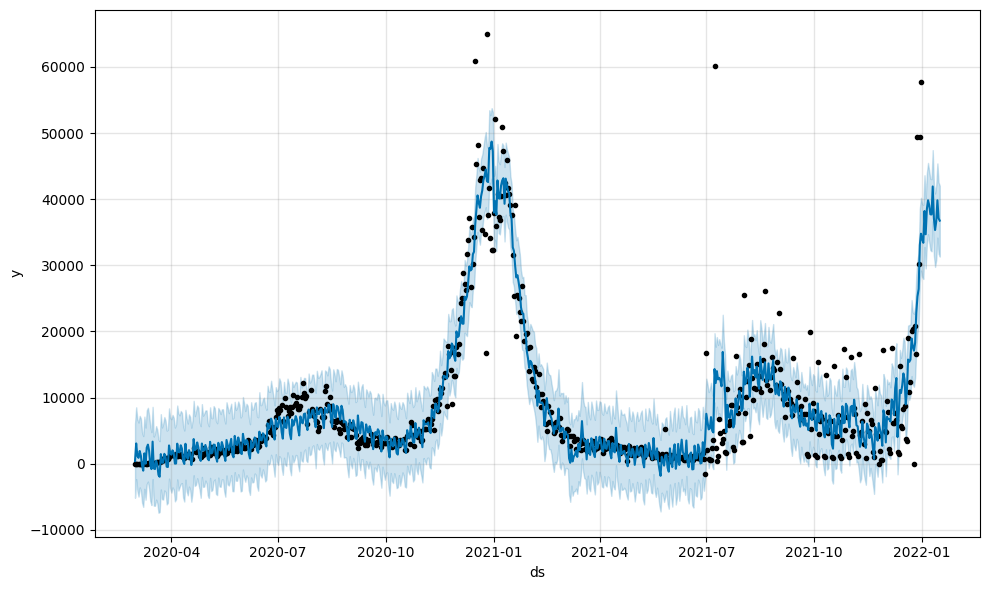

In [38]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart